Synchronize DLC results with xr_session

In [296]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data
from moviepy.editor import *
sns.set_context('paper', font_scale=1.5)


In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
def add_video_timestamp(df,videofile):
    # add timestamp of the video file to the deeplabcut dataframe
    ts = dlc_utils.extract_video_timestamp(videofile)
    df['time'] = ts
    df = df.set_index('time')
    return df

dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)
    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Get the photometry signal based on speed trigger

In [277]:
signal_time, coords, speed, accel = dlc_utils.get_movement_metrics(wrist_loc)
speed_mag = np.linalg.norm(speed,axis=1)
accel_mag = np.diff(speed_mag, prepend=speed_mag[0])

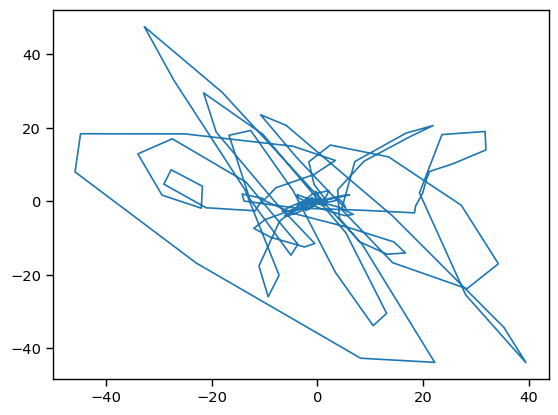

In [278]:
plt.plot(speed[:1000,0], speed[:1000,1])

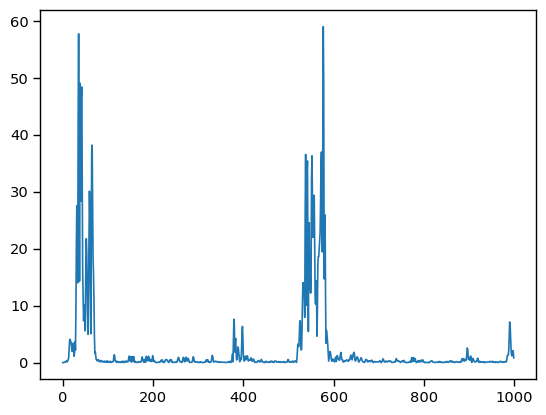

In [279]:
plt.plot(speed_mag[:1000])

**Direction of axis in image:**

- x: increase from left to right
- y: increase from top to bottom
- speed_x: -ve : left
- speed_y: -ve : up

In [280]:
f = xr_session.zscored_df_over_f.data[0]

df_move = pd.DataFrame({
    'accel': accel_mag,
    'accel_x': accel[:,0],
    'accel_y': accel[:,1],
    'speed': speed_mag,
    'speed_x': speed[:,0],
    'speed_y': speed[:,1],
    'x' : coords[:,0],
    'y' : coords[:,1],
    'time': xr_session.time,
    'df/f': f})
df_move

,accel,accel_x,accel_y,speed,speed_x,speed_y,x,y,time,df/f
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,866.019236,718.237255,7608.5,0.205254
1,0.057733,0.014156,-0.055971,0.057733,0.014156,-0.055971,866.033392,718.181284,7618.5,0.292358
2,-0.014141,0.028642,0.047690,0.043592,0.042798,-0.008280,866.076190,718.173004,7628.5,0.262030
3,0.027108,0.027034,-0.002757,0.070699,0.069833,-0.011037,866.146023,718.161967,7638.5,0.201862
4,0.015841,0.012326,-0.016152,0.086541,0.082158,-0.027190,866.228181,718.134777,7648.5,0.231352
...,...,...,...,...,...,...,...,...,...,...
176423,0.047227,-1.242300,0.265860,0.658829,-0.644407,0.137092,870.201456,747.134276,1771827.5,0.003056
176424,2.613453,-2.555329,0.548121,3.272282,-3.199736,0.685213,867.001720,747.819489,1771837.5,0.031638
176425,1.856771,-1.815902,0.387428,5.129054,-5.015639,1.072641,861.986081,748.892130,1771847.5,0.086082
176426,-0.771006,0.751912,-0.170858,4.358047,-4.263727,0.901783,857.722354,749.793913,1771857.5,0.064148


In [13]:
df_accel_forward = dlc_utils.accelerate_forward(df_move, accel_threshold=5, speed_threshold=10)
df_accel_forward

,accel,accel_x,accel_y,speed,speed_x,speed_y,time,df/f
29,6.747229,-6.147158,-7.356325,8.951048,-7.145182,-5.391442,7898.5,-0.589922
1747,6.924571,-7.024784,-3.606804,7.989691,-6.557769,-4.564080,25078.5,1.025637
1772,6.624754,-6.133382,-3.613977,8.383483,-7.803723,-3.063443,25328.5,-0.229213
2773,6.759022,-7.207261,-4.481096,8.992257,-8.572894,-2.714069,35338.5,3.197638
3230,5.474919,-3.845573,-4.375101,6.411251,-3.628207,-5.285854,39908.5,-2.016429
...,...,...,...,...,...,...,...,...
173606,7.072777,-8.016836,0.566882,7.685679,-7.685508,0.051256,1743657.5,0.022175
174681,7.281373,0.273762,-8.000275,8.133495,-0.570812,-8.113440,1754407.5,-0.839283
174750,5.597032,-3.122523,-4.707783,8.949253,-5.546938,-7.022863,1755097.5,-0.837675
175543,6.099643,-6.684888,-1.906788,6.752674,-6.634900,-1.255672,1763027.5,-0.002133


## Study movement initation

all init: 6511 valid init : 180


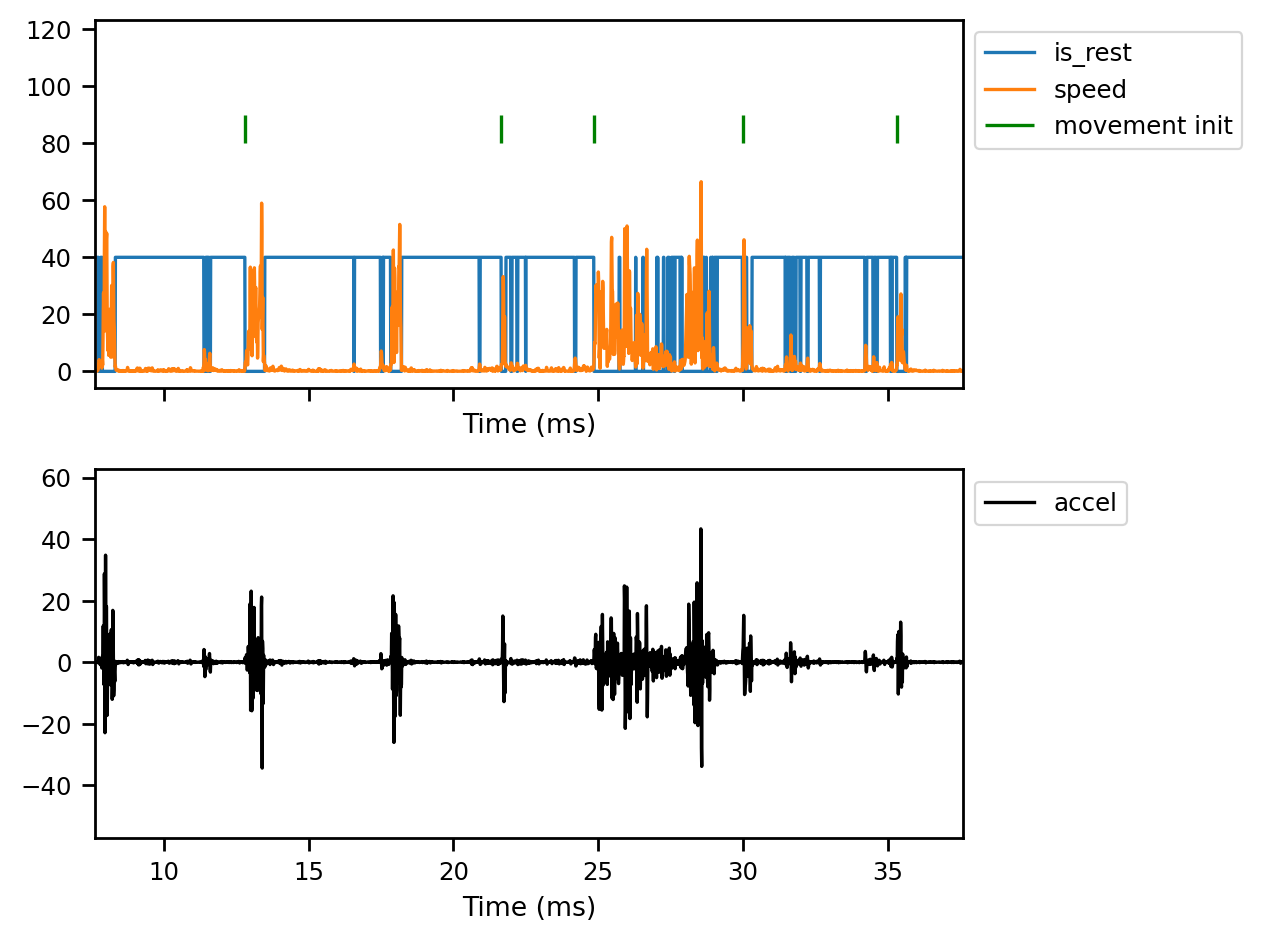

In [191]:
sns.set_context('paper')

df2plot = df_move
time = df_move.time/1000

is_moving = (df2plot.speed>5)
is_rest = ((df2plot.speed<2) & (df2plot.accel.abs()<3)).astype(np.int8)
df_move['is_rest'] = is_rest

fig,ax = plt.subplots(2,1,sharex=True, dpi=200)


ax[0].plot(time, is_rest*40, label='is_rest')
ax[0].plot(time, df2plot.speed, label='speed')

ax[1].plot(time, df2plot.accel, label='accel',color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].legend(bbox_to_anchor=[1,1], loc='upper left')

move_init_idx = np.where(np.diff(is_rest, prepend=False)==-1)[0]
# ax[0].eventplot(move_init_idx, lineoffsets = 65, linelength=10)

move_init_time = df_move.iloc[move_init_idx].time
ax[0].set_xlim([time[0],time[0]+30])


def filter_init(df_move, move_init_idx, consec_rest, consec_move):
    # filter move init only if it is proceed by some amount of consec_rest
    # followed by consec_move of movement
    # allow for some tolerance as there may be tracking error
    
    valid_init = []
    for idx in move_init_idx:
        rest_cond = df_move.iloc[(idx-consec_rest):idx].is_rest.mean() > 0.9
        move_cond = df_move.iloc[idx:(idx+consec_move)].is_rest.mean() < 0.1
        if (rest_cond and move_cond):
            valid_init.append(idx)
            
    return valid_init

valid_init = filter_init(df_move, move_init_idx,50, 10)
valid_init_time = df_move.iloc[valid_init].time

ax[0].eventplot(time[valid_init], lineoffsets = 85, linelength=10, color='g', label='movement init')
ax[0].set_xlabel('Time (ms)')
ax[0].legend(bbox_to_anchor=[1,1], loc='upper left')

fig.tight_layout()

fig.savefig('move_init.png',dpi=200, bbox_inches='tight')

print(f'all init: {len(move_init_idx)} valid init : {len(valid_init)}')

Extracted 179 events


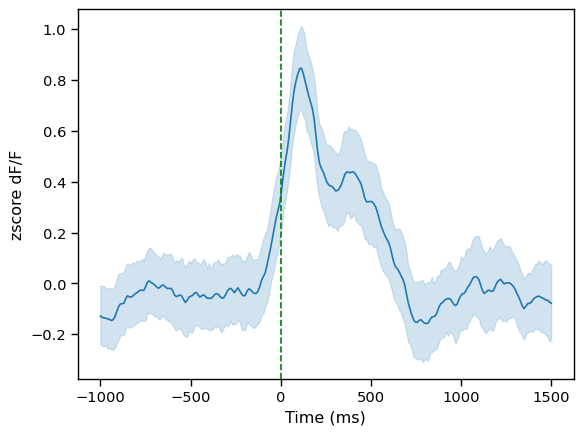

In [260]:
# xr_sessoin is at 100Hz
sns.set_context('paper', font_scale=1.2)

df_init = dlc_utils.extract_triggered_data(valid_init_time, xr_session, [-1000, 1500],
                                             sampling_rate=100)
ax = sns.lineplot(df_init, x='event_time', y='photometry')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_move_init.png',dpi=200)

In [221]:
dlc_utils.extract_sample_video_multi(videofile, 'move_int', 
                                     valid_init_time[:5].values, video_type='gif', resize_ratio=0.5)

Saved sample_video/move_int_24
Saved sample_video/move_int_12
Saved sample_video/move_int_21
Saved sample_video/move_int_29
Saved sample_video/move_int_35


### Separate into forward and backward movement

In [298]:

def get_direction(df_move, move_init_idx, window=10):
    direction = []
    for idx in move_init_idx:
        speed_x_mean =df_move.iloc[(idx):(idx+window)].speed_x.mean()
        if speed_x_mean <0:
            d = 'forward'
        else:
            d = 'backward'
        
        direction.append(d)
    return direction

def get_average_speed(df_move, move_init_idx, window=10):
    speed = []
    for idx in move_init_idx:
        speed_mean =df_move.iloc[(idx):(idx+window)].speed.mean()
        speed.append(speed_mean)
    return speed

def get_movement_type(df_move, move_init_idx, threshold, window=10):
    # get the starting pos and ending pos to find the displacement
    mov_type = []
    for idx in move_init_idx:
        start_pos = df_move.iloc[idx].x
        end_pos = df_move.iloc[idx+window].x
        displacement = end_pos - start_pos
        
        if abs(displacement)>threshold:
            mov_type.append('reach')
        else:
            mov_type.append('twitch')
        
    return mov_type

direction = get_direction(df_move, valid_init)
speed = get_average_speed(df_move, valid_init)
mov_type = get_movement_type(df_move, valid_init, 100, window=50)
speed_cls = pd.qcut(df_init_time.speed,3, labels=['slow','middle','fast'])

df_init_time =  pd.DataFrame({'event_index':np.arange(len(direction)), 
                              'init_time': valid_init_time,
                              'speed': speed,
                              'speed_class': speed_cls,
                              'move_type': mov_type,
                              'direction':direction})

# display(df_init_time)
display(df_init_time.groupby(['direction','move_type']).count())
df_init2 = df_init.merge(df_init_time, on='event_index')
df_init2

event_index  init_time  speed  speed_class
direction move_type                                            
backward  reach               32         32     32           32
          twitch              31         31     31           31
forward   reach               18         18     18           18
          twitch              99         99     99           99

,event_index,event_time,photometry,init_time,speed,speed_class,move_type,direction
0,0,-1000.000000,-0.061872,12808.5,4.022312,slow,reach,forward
1,0,-989.959839,0.020588,12808.5,4.022312,slow,reach,forward
2,0,-979.919679,-0.008874,12808.5,4.022312,slow,reach,forward
3,0,-969.879518,-0.077045,12808.5,4.022312,slow,reach,forward
4,0,-959.839357,-0.294679,12808.5,4.022312,slow,reach,forward
...,...,...,...,...,...,...,...,...
44995,179,1459.839357,NaN,1770477.5,23.477346,fast,reach,backward
44996,179,1469.879518,NaN,1770477.5,23.477346,fast,reach,backward
44997,179,1479.919679,NaN,1770477.5,23.477346,fast,reach,backward
44998,179,1489.959839,NaN,1770477.5,23.477346,fast,reach,backward


,event_time,photometry,init_time,speed,speed_class
direction,,,,,
backward,40,39,40,40,40
forward,80,80,80,80,80


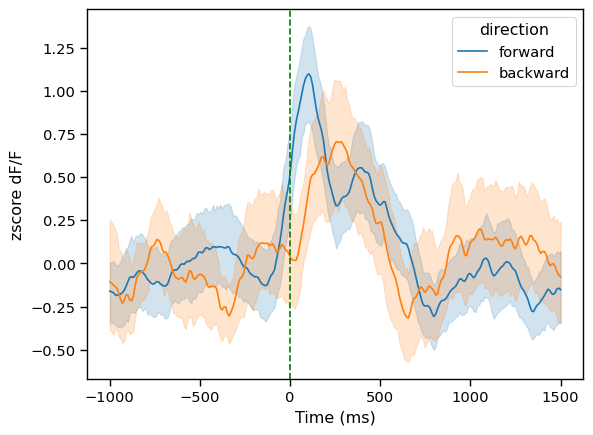

In [262]:
df2plot = df_init2[df_init2.speed>10]
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

ax = sns.lineplot(df2plot, x='event_time', y='photometry', hue='direction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_movement_direction.png',dpi=200)

In [244]:
forward_time = df_init_time.query("direction=='forward' and speed_class!= 'slow'").init_time.values
backward_time = df_init_time.query("direction=='backward' and speed_class!= 'slow'").init_time.values

dlc_utils.extract_sample_video_multi(videofile, 'move_int_forward', 
                                     forward_time[:5], video_type='gif', resize_ratio=0.4)

dlc_utils.extract_sample_video_multi(videofile, 'move_int_backward', 
                                     backward_time[:5], video_type='gif', resize_ratio=0.4)

Saved sample_video/move_int_forward_24
Saved sample_video/move_int_forward_21
Saved sample_video/move_int_forward_61
Saved sample_video/move_int_forward_35
Saved sample_video/move_int_forward_45
Saved sample_video/move_int_backward_29
Saved sample_video/move_int_backward_273
Saved sample_video/move_int_backward_252
Saved sample_video/move_int_backward_337
Saved sample_video/move_int_backward_310


### Movement speed

,event_time,photometry,init_time,speed,speed_class
direction,,,,,
backward,63,62,63,63,63
forward,117,117,117,117,117


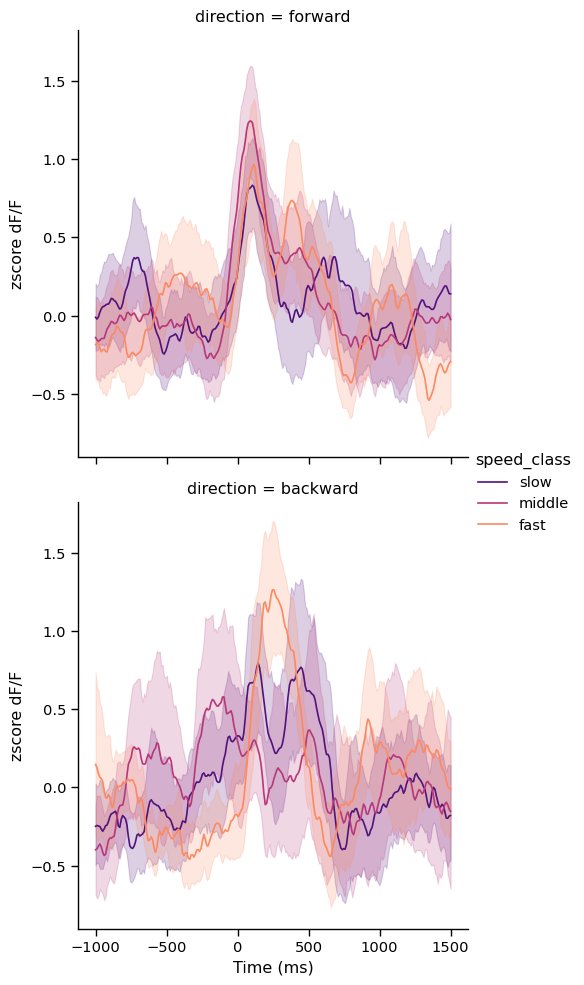

In [265]:
df2plot = df_init2
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', row='direction', hue='speed_class', palette='magma')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_direction.png',dpi=200)

In [273]:
df_speed_class = df_init_time.groupby(['speed_class','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.speed_class}', 
                                     [row.init_time], video_type='gif', resize_ratio=0.4)

Saved sample_video/backward_slow_42
Saved sample_video/forward_slow_12
Saved sample_video/backward_middle_337
Saved sample_video/forward_middle_21
Saved sample_video/backward_fast_29
Saved sample_video/forward_fast_24


## Movement type

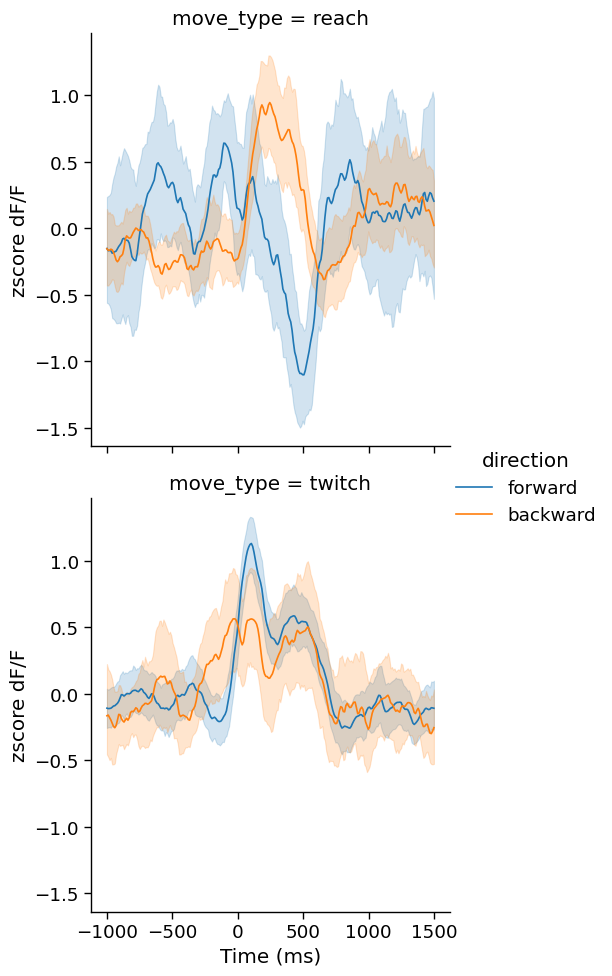

In [299]:
df2plot = df_init2

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', hue='direction', row='move_type')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_type.png',dpi=200)

In [291]:
df_speed_class = df_init_time.groupby(['move_type','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.move_type}', 
                                     [row.init_time], video_type='gif', resize_ratio=0.4)

Saved sample_video/backward_reach_29
Saved sample_video/forward_reach_12
Saved sample_video/backward_twist_42
Saved sample_video/forward_twist_21


## Identify contagious regions

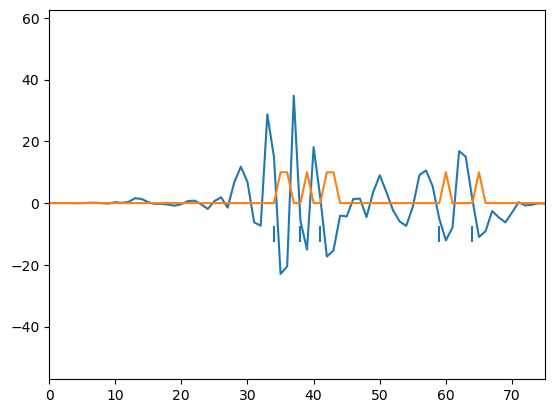

In [15]:
fig,ax = plt.subplots()

a = np.diff(speed_mag)


condition  = (a<-10).astype(np.int8)

ax.plot(a)
ax.plot(condition*10)
ax.set_xlim([0,75])

event_idx = np.where(np.diff(condition)==1)[0]
ax.eventplot(event_idx, lineoffset=-10, linelength=5)

event_time = xr_session.time[event_idx]
# event_time = np.random.choice(xr_session.time,1000)

(0.0, 200.0)

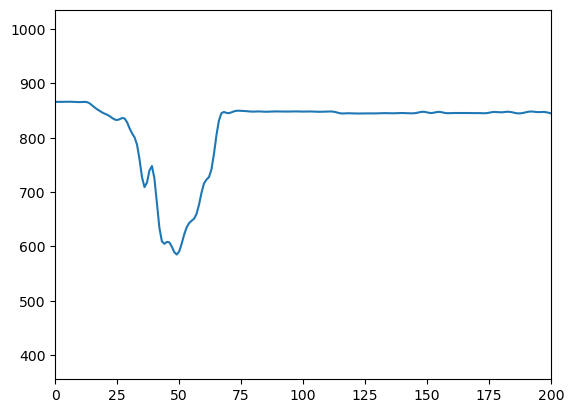

In [16]:
plt.plot(coords[:,0])
plt.xlim([0,200])

 Things to study
 - Forward aceleration and backward acceleration
 - acceleraton and deceleration

## Extract photometry data based on movement

<Axes: xlabel='event_time', ylabel='photometry'>

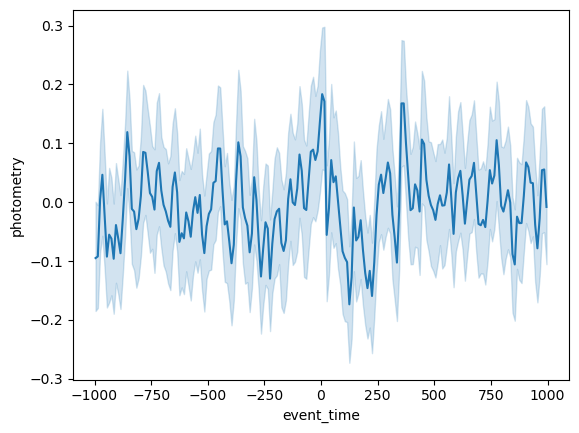

In [17]:
df_forward = dlc_utils.extract_triggered_data(df_accel_forward.time, xr_session)
sns.lineplot(df_forward, x='event_time', y='photometry')

In [18]:
df_trigger = dlc_utils.extract_trigger_acceleration(df_move, accel_threshold=5, 
                                                            speed_threshold=5, accel_type='decel', 
                                                            direction='forward')
df_trigger

,accel,accel_x,accel_y,speed,speed_x,speed_y,time,df/f
32,-6.205589,2.066645,5.851440,21.358222,-7.231911,-20.096594,7928.5,-0.771798
33,-7.345911,-6.427274,23.222540,14.012311,-13.659184,3.125945,7938.5,-0.667507
36,-22.932546,14.675482,-17.809541,34.801978,-18.038180,29.762422,7968.5,-0.615949
40,-15.071500,-31.067579,25.897267,28.365429,-22.883277,-16.761660,8008.5,-1.563303
43,-17.325934,19.703217,-0.040593,31.087698,-25.065028,18.389925,8038.5,-2.053078
...,...,...,...,...,...,...,...,...
175971,-21.970655,20.361820,9.806776,25.013948,-17.872326,-17.500787,1767307.5,-0.509900
176002,-8.348157,6.432889,5.513833,10.822963,-9.601562,-4.994650,1767617.5,-0.709403
176038,-15.285271,13.593844,7.037366,18.248252,-15.550880,-9.548238,1767977.5,-0.196495
176314,-5.056081,3.826931,-3.715974,15.253312,-6.275265,13.902682,1770737.5,0.598893


In [149]:
df2plot = []
for accel_type in ['accel','decel']:
    for direction in ['forward','backward']:
        
        if accel_type == 'accel':
            speed_threshold = 10
            accel_threshold = 5
        else:
            speed_threshold = 10
            accel_threshold = 10
        
        df_trigger = dlc_utils.extract_trigger_acceleration(df_move, accel_threshold=accel_threshold, 
                                                            speed_threshold=speed_threshold, 
                                                            accel_type=accel_type, 
                                                            direction=direction)
        print(accel_type, direction, len(df_trigger))
        # dlc_utils.extract_sample_video(videofile, df_trigger.sample(10), f'{accel_type}_{direction}')
        df = dlc_utils.extract_triggered_data(df_trigger.time, xr_session,[-1000,1000],sampling_rate=100)
        df['accel_type'] = accel_type
        df['direction'] = direction
        df2plot.append(df)
        
df2plot = pd.concat(df2plot).reset_index()
df2plot

accel forward 315
(315, 200)
Extracted 314 events
accel backward 595
(595, 200)
Extracted 595 events
decel forward 1177
(1177, 200)
Extracted 1173 events
decel backward 549
(549, 200)
Extracted 546 events


,index,event_index,event_time,photometry,accel_type,direction
0,0,0,-954.773869,NaN,accel,forward
1,1,0,-854.271357,NaN,accel,forward
2,2,0,-753.768844,NaN,accel,forward
3,3,0,-653.266332,NaN,accel,forward
4,4,0,-552.763819,NaN,accel,forward
...,...,...,...,...,...,...
52715,10975,548,552.763819,-0.576152,decel,backward
52716,10976,548,653.266332,-0.165257,decel,backward
52717,10977,548,753.768844,-0.014903,decel,backward
52718,10978,548,854.271357,0.591307,decel,backward


## TODO
- Segregate based on position

AttributeError: module 'matplotlib.pylab' has no attribute 'adjust_subplots'

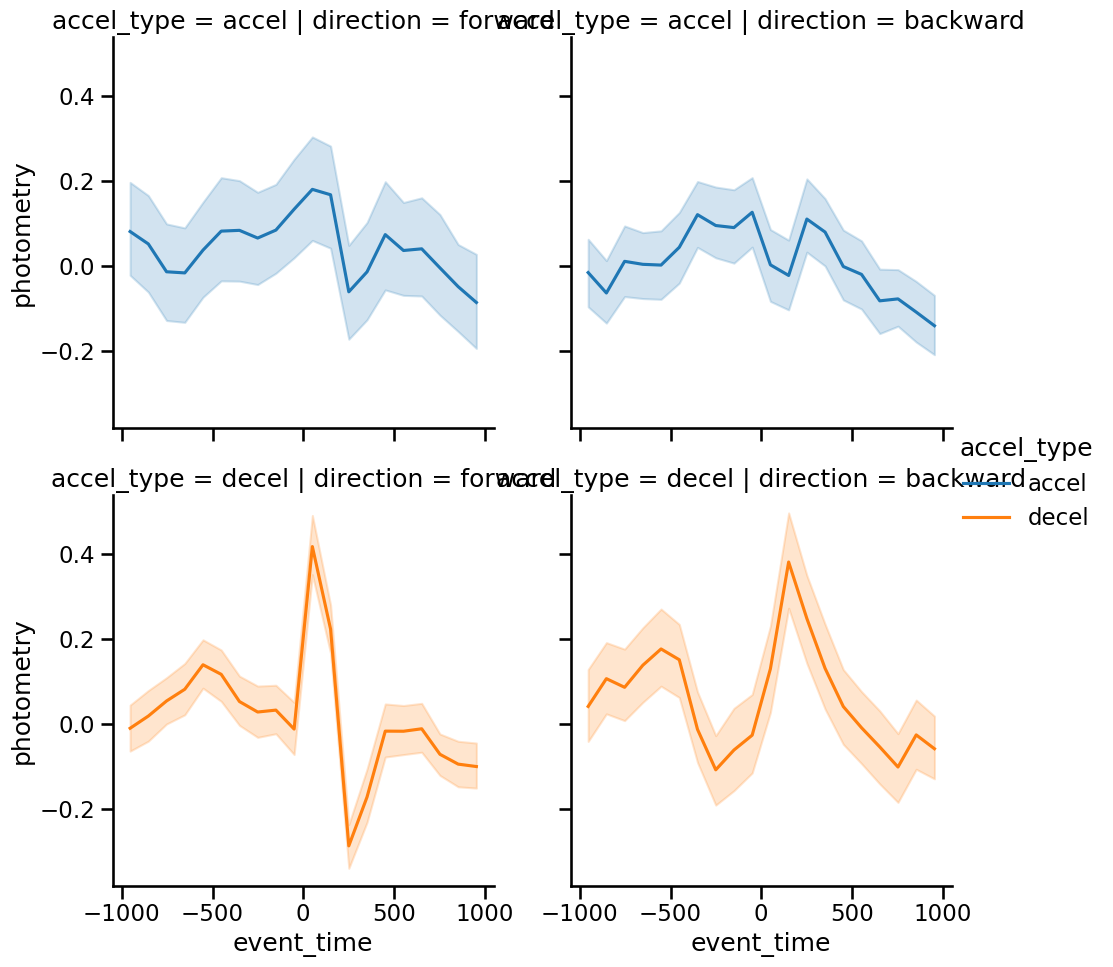

In [153]:
sns.set_context('talk')
sns.relplot(df2plot, kind='line', x='event_time', y='photometry', hue='accel_type', 
            row='accel_type', col='direction')
plt.adjust_subplots(wspace=0.2)

## Distribution analysis

<Axes: xlabel='accel', ylabel='df/f'>

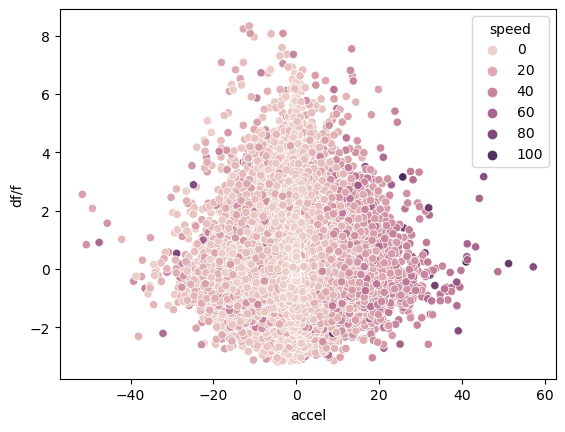

In [12]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

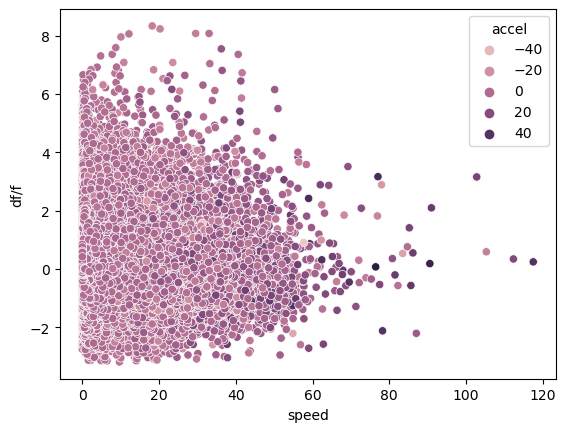

In [13]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')